# Climbing the causal ladder for fun and profit

Talk at at PyData Global 2024

Benjamin T. Vincent

## Notebook setup

See `README.md` for instructions on setting up an environment to run this notebook.

In [1]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
from IPython.display import Image

from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
plt.rcParams.update({"figure.constrained_layout.use": True})
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
seed: int = sum(map(ord, "ladder"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

/Users/benjamv/miniforge3/envs/pydata_global_2024_causal_ladder/lib/python3.12/site-packages/pytensor/tensor/random/op.py:83: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/benjamv/miniforge3/envs/pydata_global_2024_causal_ladder/lib/python3.12/site-packages/pytensor/tensor/random/op.py:93: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(


## Causal view of a demand forecasting situation

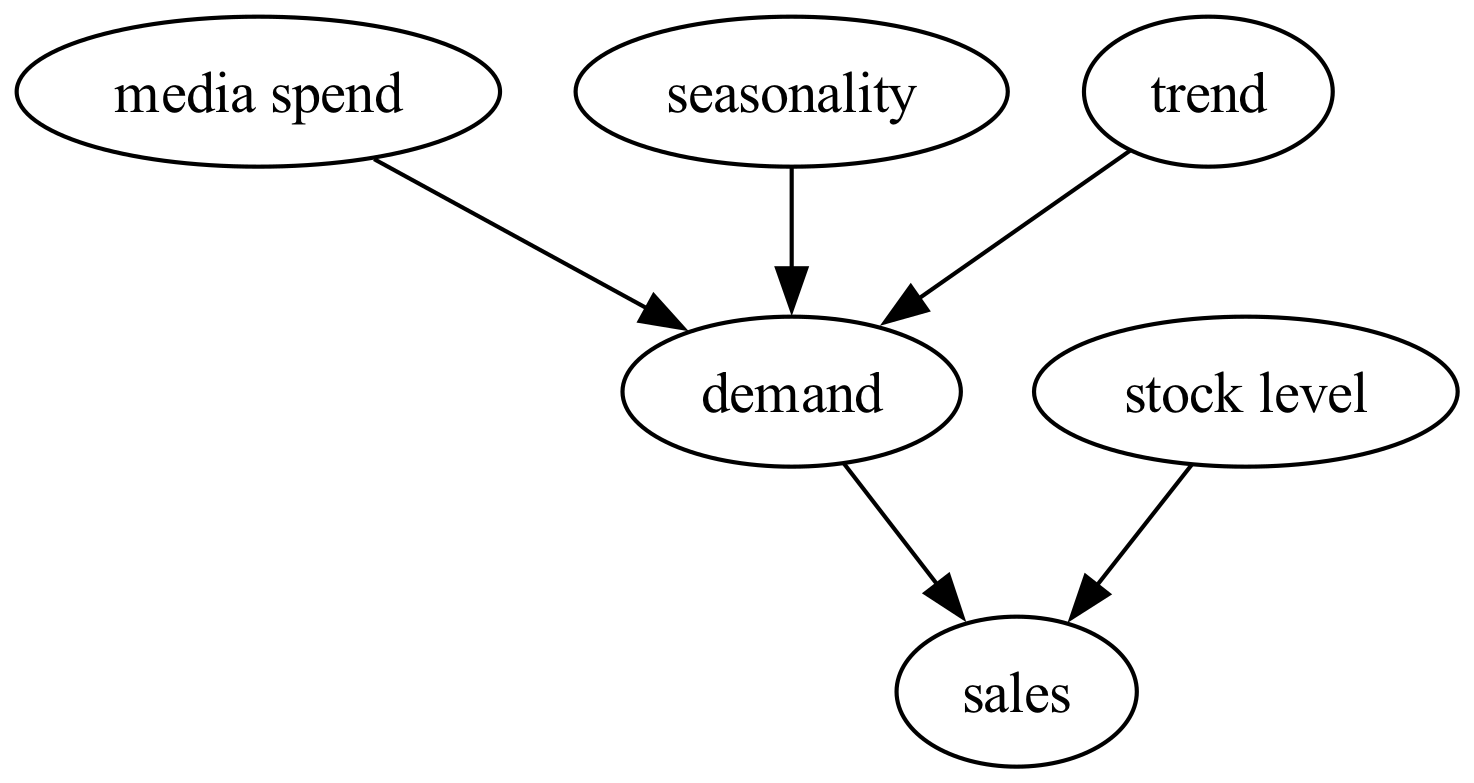

In [2]:
g = gr.Digraph(format="png", graph_attr={"dpi": "300"})
# nodes
g.node(name="media", label="media spend")
g.node(name="seas", label="seasonality")
g.node(name="trend", label="trend")
g.node(name="d", label="demand")
g.node(name="s", label="sales")
g.node(name="instock", label="stock level")
# edges
g.edge("media", "d")
g.edge("seas", "d")
g.edge("trend", "d")
g.edge("d", "s")
g.edge("instock", "s")
# render
g.render(filename="dag")
Image(filename="dag.png")

## Generate some data

In [3]:
def generate_fourier_basis(
    df: pd.DataFrame, day_col: str = "dayofyear", *, n_order: int, period: float = 365.5
) -> pd.DataFrame:
    """
    Generate Fourier basis functions for time series seasonality modeling.

    Parameters:
    - df: pandas DataFrame
        The DataFrame to which the Fourier basis functions will be added.
    - day_col: str, default "dayofyear"
        The column in `df` representing the day of the year (e.g., 1 to 365).
    - n_order: int, default 10
        The number of Fourier basis function orders to generate.
    - period: float, default 365.5
        The period of the seasonal cycle (e.g., 365.5 for a year).

    Returns:
    - pandas DataFrame: The input DataFrame with Fourier basis columns added.
    """
    for order in range(1, n_order + 1):
        df[f"sin_order_{order}"] = np.sin(2 * np.pi * order * df[day_col] / period)
        df[f"cos_order_{order}"] = np.cos(2 * np.pi * order * df[day_col] / period)
    return df


def extract_seasonality_to_array(df: pd.DataFrame) -> np.ndarray:
    """Extract the seasonality terms from the DataFrame and return as an array."""
    sin_cos_columns = [
        col for col in df.columns if col.startswith("sin_") or col.startswith("cos_")
    ]
    return df[sin_cos_columns].to_numpy()

In [4]:
seasonality_norder = 4

params = {
    "intercept": 2.0,
    "linear_trend_slope": 0.01,
    "channels": ["x1", "x2"],
    "beta": [3.0, 1.5],
    "lam": [4.0, 3.0],
    "alpha": [0.4, 0.2],
    "sigma": 0.5,
    "seasonality_norder": seasonality_norder,
    "seasonality_weights": rng.uniform(-1, 1, size=(2 * seasonality_norder)),
    "stock_level": 6.0,
}

params

{'intercept': 2.0,
 'linear_trend_slope': 0.01,
 'channels': ['x1', 'x2'],
 'beta': [3.0, 1.5],
 'lam': [4.0, 3.0],
 'alpha': [0.4, 0.2],
 'sigma': 0.5,
 'seasonality_norder': 4,
 'seasonality_weights': array([ 0.83776653, -0.07640765,  0.01794572, -0.85602   ,  0.34405399,
        -0.43579259, -0.23477177, -0.70992285]),
 'stock_level': 6.0}

In [5]:
def generate_exogenous_variables(params, rng):
    df = pd.DataFrame().assign(
        date_week=pd.date_range(
            start=pd.to_datetime("2019-04-01"),
            end=pd.to_datetime("2021-09-01"),
            freq="W-MON",
        ),
        # year=lambda x: x["date_week"].dt.year,
        # month=lambda x: x["date_week"].dt.month,
        dayofyear=lambda x: x["date_week"].dt.dayofyear,  # used for seasonal effects
        t=lambda x: range(x.shape[0]),
        stock_level=params["stock_level"],
    )

    n_rows = df.shape[0]

    _x1 = rng.uniform(low=0.0, high=1.0, size=n_rows)
    df["x1"] = np.where(_x1 > 0.8, _x1, _x1 / 2)

    _x2 = rng.uniform(low=0.0, high=1.0, size=n_rows)
    df["x2"] = np.where(_x2 > 0.8, _x2, _x2 / 4)

    df = generate_fourier_basis(
        df, day_col="dayofyear", n_order=params["seasonality_norder"], period=365.5
    )
    return df

In [6]:
exogenous = generate_exogenous_variables(params, rng)
exogenous.head()

,date_week,dayofyear,t,stock_level,x1,x2,sin_order_1,cos_order_1,sin_order_2,cos_order_2,sin_order_3,cos_order_3,sin_order_4,cos_order_4
0,2019-04-01,91,0,6.0,0.308792,0.047332,0.999979,0.006446,0.012893,-0.999917,-0.999813,-0.019338,-0.025783,0.999668
1,2019-04-08,98,1,6.0,0.363577,0.174313,0.993522,-0.113642,-0.225812,-0.974171,-0.942198,0.335056,0.439958,0.898018
2,2019-04-15,105,2,6.0,0.977898,0.071156,0.972695,-0.232087,-0.451500,-0.892271,-0.763121,0.646256,0.805720,0.592296
3,2019-04-22,112,3,6.0,0.280721,0.181987,0.937800,-0.347175,-0.651162,-0.758939,-0.485666,0.874145,0.988384,0.151976
4,2019-04-29,119,4,6.0,0.306665,0.034884,0.889342,-0.457242,-0.813290,-0.581859,-0.145601,0.989343,0.946440,-0.322880


In [7]:
# run marketing intervention on x1 here
# business as ususal scenario is x1
exogenous["x1_counterfactual"] = exogenous["x1"]
# but in reality, we ran elevated advertising in a campaign period
exogenous.loc[80:99, "x1"] = 0.8

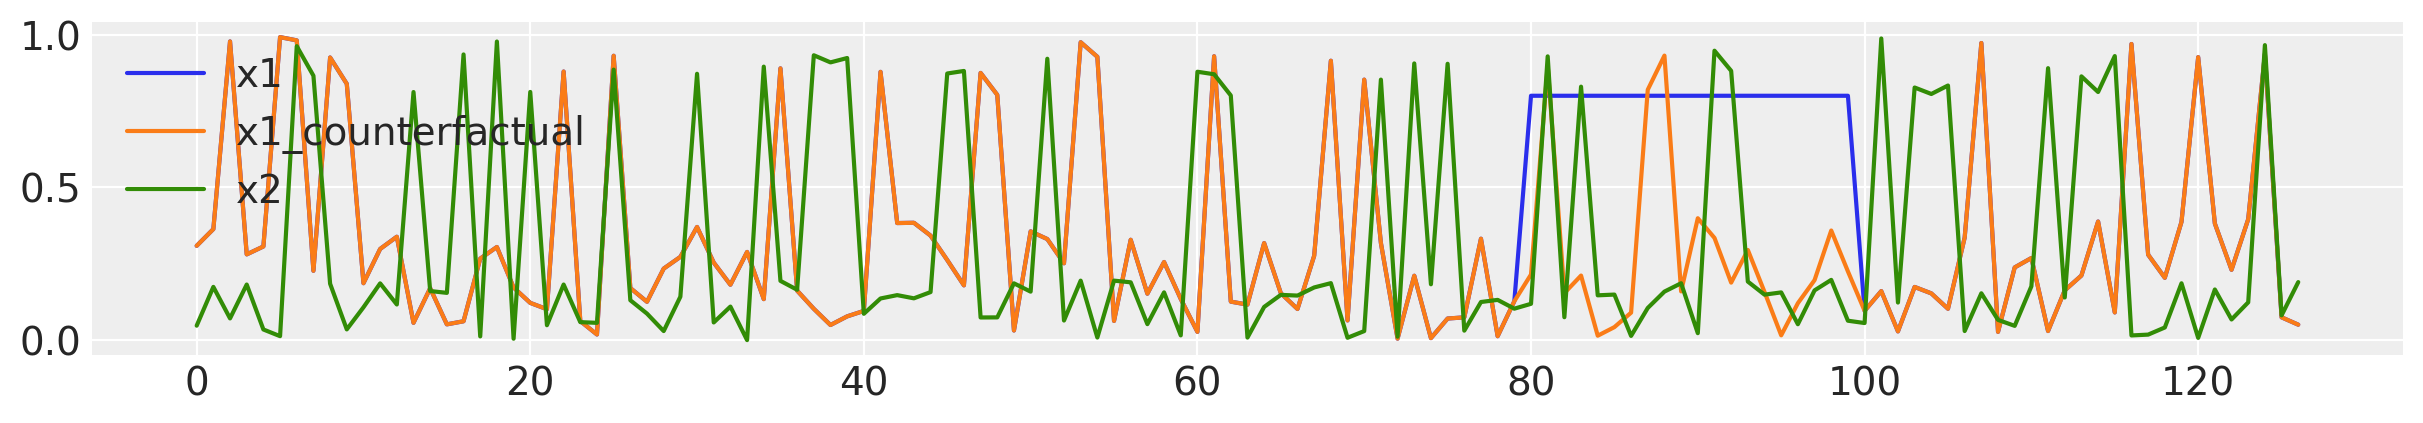

In [8]:
exogenous[["x1", "x1_counterfactual", "x2"]].plot(figsize=(12, 2));

### Define the PyMC model

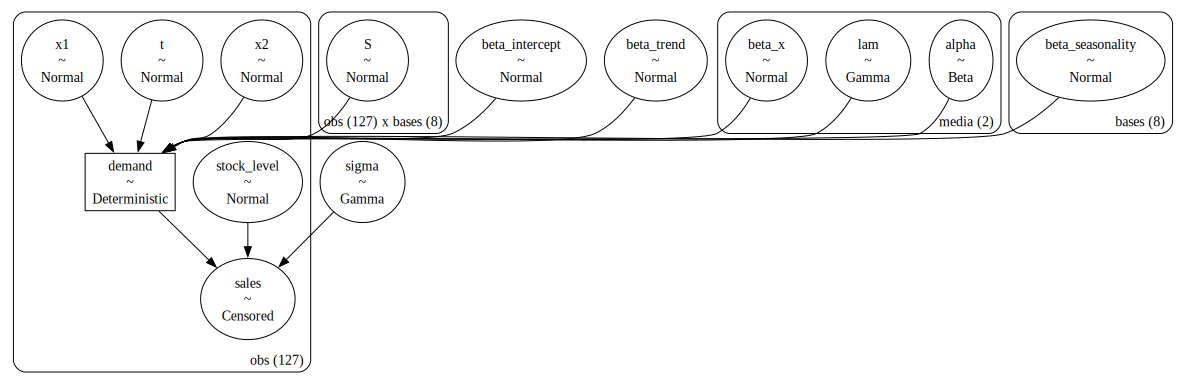

In [9]:
def apply_media_transformations(x, alpha, lam, l_max):
    x_adstocked = geometric_adstock(x, alpha=alpha, l_max=l_max, normalize=True)
    x_saturated = logistic_saturation(x=x_adstocked, lam=lam)
    return x_saturated


coords = {"obs": exogenous["t"], "bases": np.arange(8), "media": ["x1", "x2"]}

with pm.Model(coords=coords) as model:
    # Data
    t = pm.Normal("t", dims="obs")
    x1 = pm.Normal("x1", dims="obs")
    x2 = pm.Normal("x2", dims="obs")
    S = pm.Normal("S", dims=("obs", "bases"))
    stock_level = pm.Normal("stock_level", dims="obs")

    # Priors
    beta_intercept = pm.Normal("beta_intercept", mu=0, sigma=1)
    beta_trend = pm.Normal("beta_trend", mu=0, sigma=1)
    beta_x = pm.Normal("beta_x", mu=0, sigma=1, dims="media")
    beta_seasonality = pm.Normal("beta_seasonality", mu=0, sigma=1, dims="bases")
    sigma = pm.Gamma("sigma", 1, 1)

    alpha = pm.Beta("alpha", alpha=1, beta=1, dims="media")
    lam = pm.Gamma("lam", alpha=1, beta=1, dims="media")

    # apply media transformations
    x1_saturated = apply_media_transformations(x1, alpha=alpha[0], lam=lam[0], l_max=8)
    x2_saturated = apply_media_transformations(x2, alpha=alpha[1], lam=lam[1], l_max=8)

    demand = pm.Deterministic(
        "demand",
        beta_intercept
        + beta_trend * t
        + beta_x[0] * x1_saturated
        + beta_x[1] * x2_saturated
        + pm.math.dot(S, beta_seasonality),
        dims="obs",
    )

    # Likelihood
    normal_dist = pm.Normal.dist(mu=demand, sigma=sigma)
    censored_normal = pm.Censored(
        "sales",
        normal_dist,
        lower=0.0,
        upper=stock_level,
        dims="obs",
    )

pm.model_to_graphviz(model)

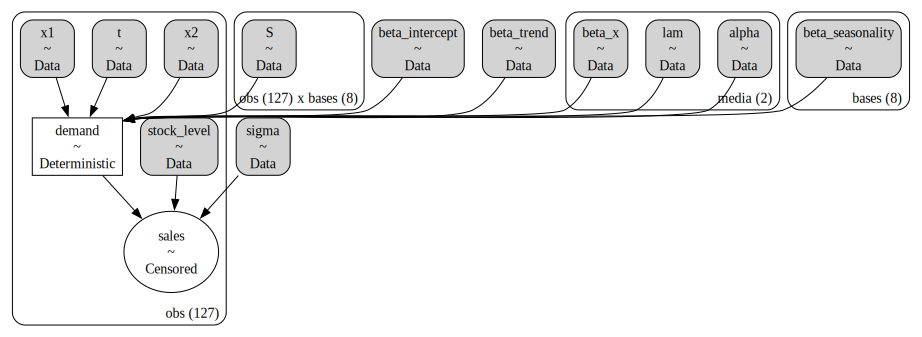

In [10]:
obs = {
    # exogenous variables
    "t": exogenous["t"],
    "x1": exogenous["x1"],
    "x2": exogenous["x2"],
    "S": extract_seasonality_to_array(exogenous),
    "stock_level": exogenous["stock_level"],
    # parameters
    "beta_intercept": params["intercept"],
    "beta_trend": params["linear_trend_slope"],
    "beta_x": params["beta"],
    "beta_seasonality": params["seasonality_weights"],
    "sigma": params["sigma"],
    "alpha": params["alpha"],
    "lam": params["lam"],
}
model_simulate = pm.do(model, obs)

pm.model_to_graphviz(model_simulate)

In [11]:
with model_simulate:
    simulate = pm.sample_prior_predictive(
        samples=1, random_seed=seed, var_names=["demand", "sales"]
    )

# Now we have our simulated dataset
exogenous["sales"] = simulate.prior.sales.data.squeeze()

Sampling: [sales]


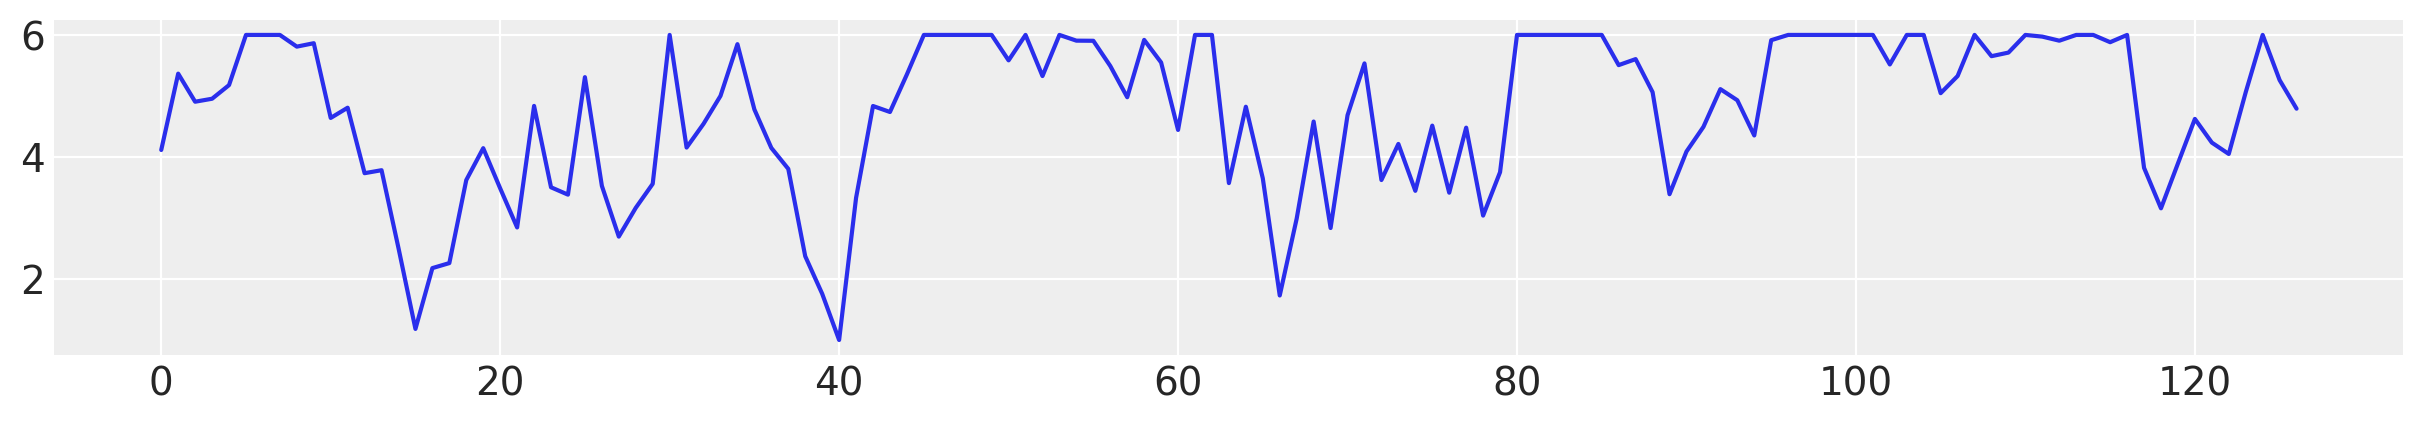

In [12]:
exogenous["sales"].plot(figsize=(12, 2));

### Summary of the data

In [13]:
exogenous.head()

,date_week,dayofyear,t,stock_level,x1,x2,sin_order_1,cos_order_1,sin_order_2,cos_order_2,sin_order_3,cos_order_3,sin_order_4,cos_order_4,x1_counterfactual,sales
0,2019-04-01,91,0,6.0,0.308792,0.047332,0.999979,0.006446,0.012893,-0.999917,-0.999813,-0.019338,-0.025783,0.999668,0.308792,4.112671
1,2019-04-08,98,1,6.0,0.363577,0.174313,0.993522,-0.113642,-0.225812,-0.974171,-0.942198,0.335056,0.439958,0.898018,0.363577,5.364831
2,2019-04-15,105,2,6.0,0.977898,0.071156,0.972695,-0.232087,-0.451500,-0.892271,-0.763121,0.646256,0.805720,0.592296,0.977898,4.904498
3,2019-04-22,112,3,6.0,0.280721,0.181987,0.937800,-0.347175,-0.651162,-0.758939,-0.485666,0.874145,0.988384,0.151976,0.280721,4.953214
4,2019-04-29,119,4,6.0,0.306665,0.034884,0.889342,-0.457242,-0.813290,-0.581859,-0.145601,0.989343,0.946440,-0.322880,0.306665,5.176775


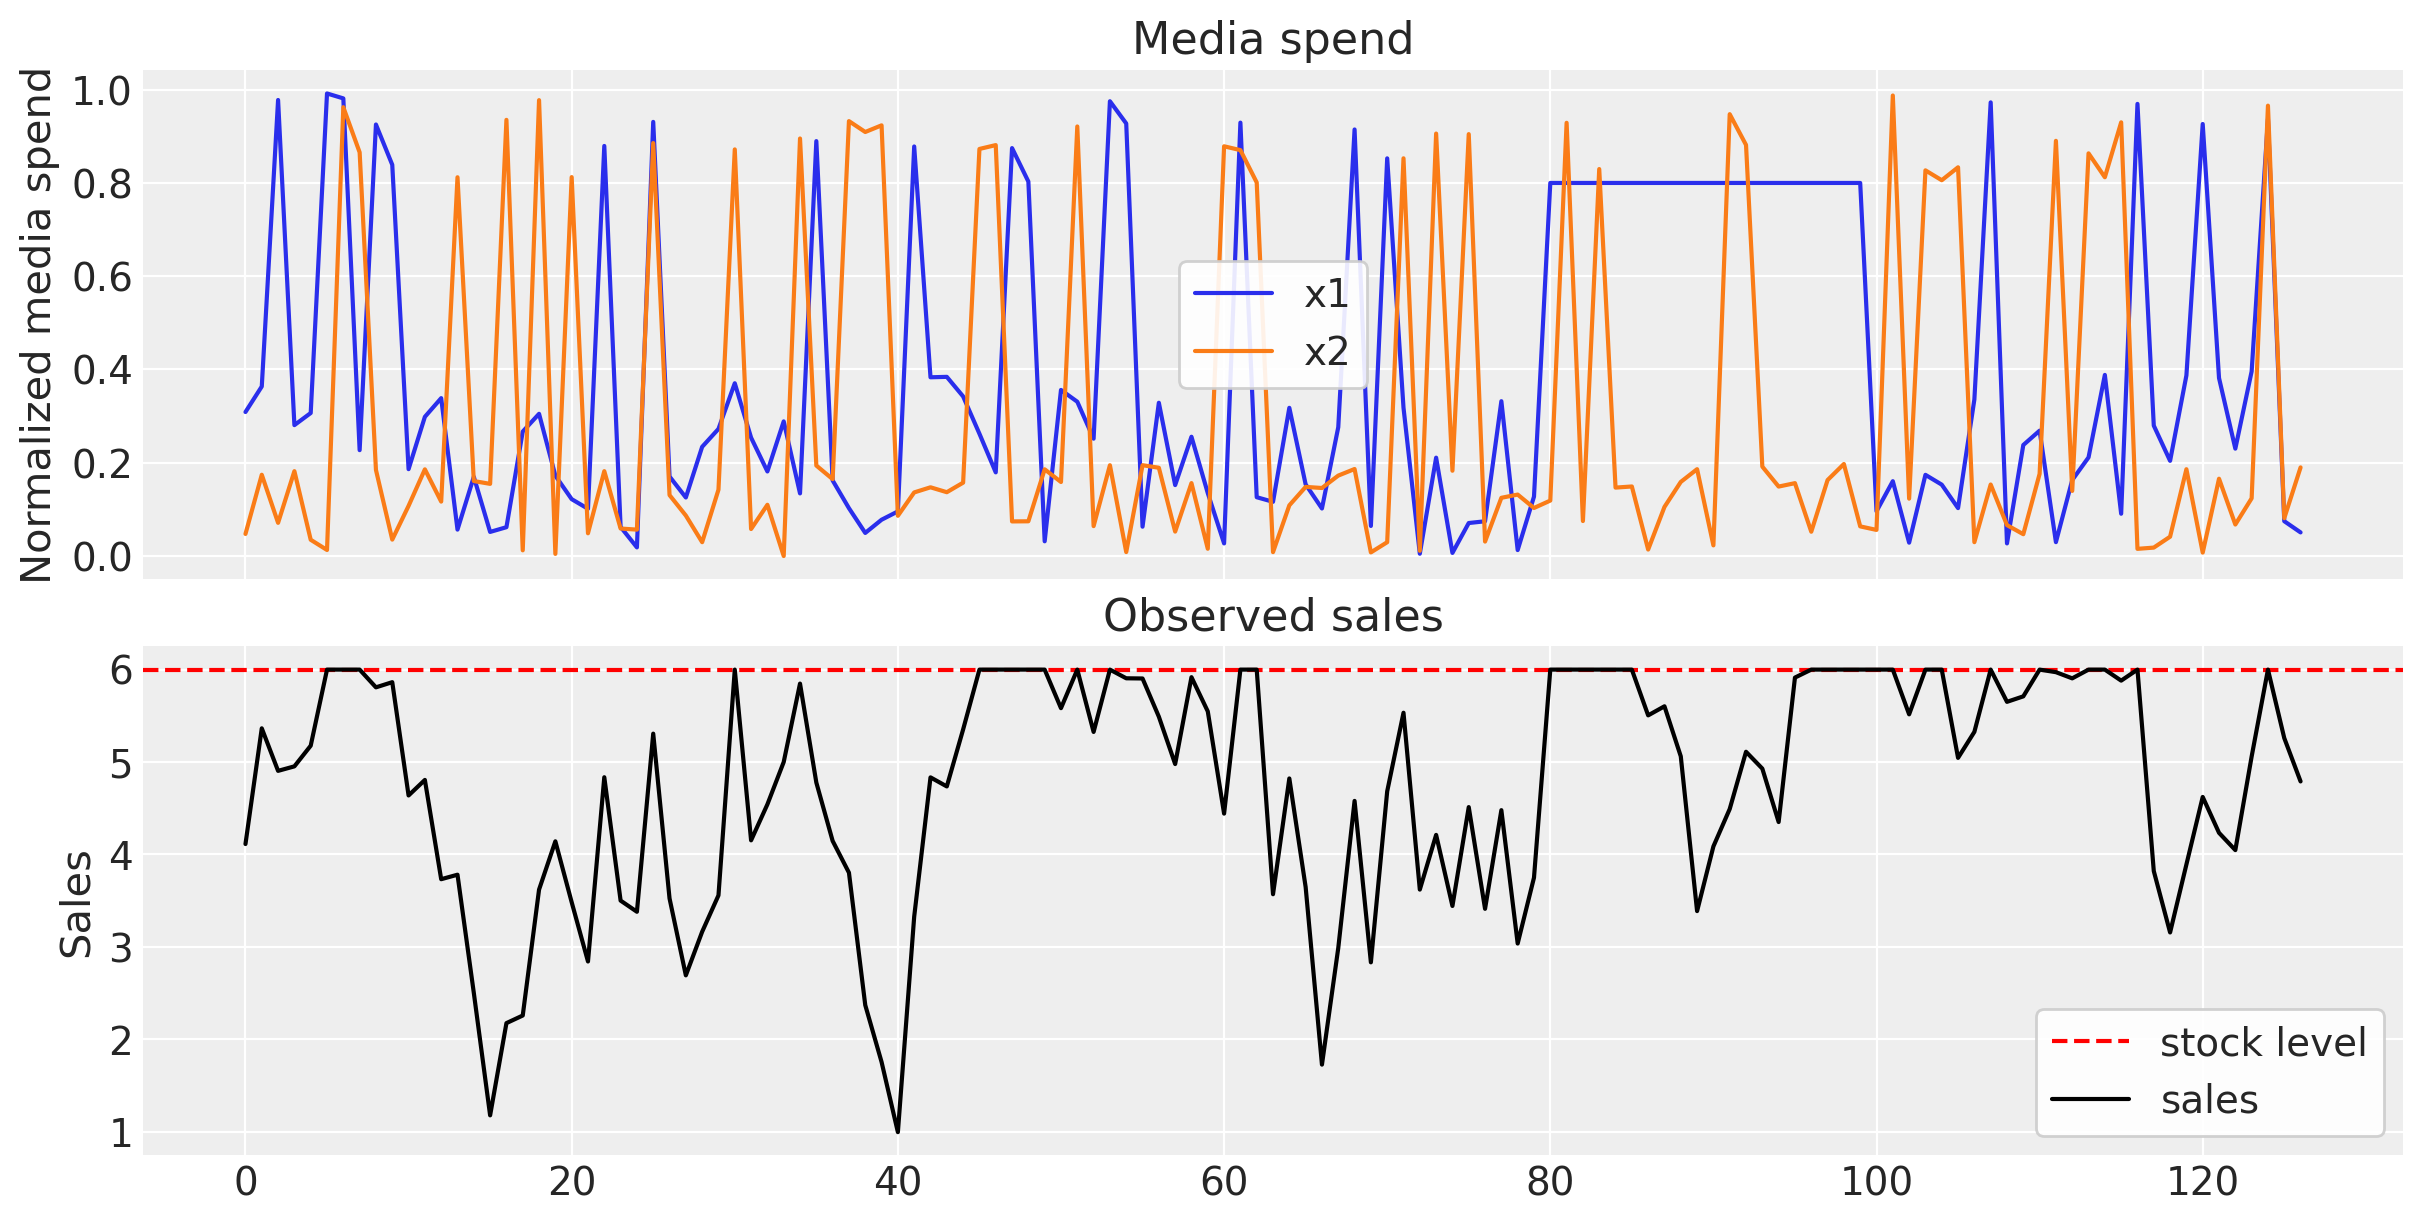

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax[0].plot(exogenous["t"], exogenous["x1"], label="x1")
ax[0].plot(exogenous["t"], exogenous["x2"], label="x2")
ax[0].legend(frameon=True, facecolor="white", framealpha=0.9)
ax[0].set(ylabel="Normalized media spend", title="Media spend")

ax[1].axhline(y=params["stock_level"], color="red", linestyle="--", label="stock level")
ax[1].plot(exogenous["t"], exogenous["sales"], "k", label="sales")
ax[1].legend(frameon=True, facecolor="white", framealpha=0.9)
ax[1].set(ylabel="Sales", title="Observed sales");

# plt.savefig(
#     "img/data_available_to_us.png", bbox_inches="tight", dpi=300, facecolor="white"
# )

## Fit the model to the data

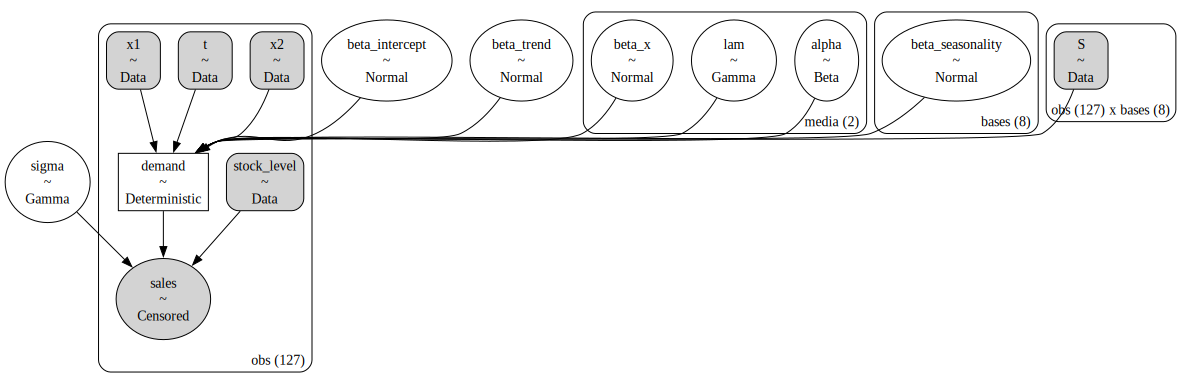

In [15]:
obs = {
    "t": exogenous["t"],
    "x1": exogenous["x1"],
    "x2": exogenous["x2"],
    "S": extract_seasonality_to_array(exogenous),
    "stock_level": exogenous["stock_level"],
}

# do operator for exogenous variables
inference_model = pm.do(model, obs)
# observe operator for outcome
inference_model = pm.observe(inference_model, {"sales": exogenous["sales"]})

pm.model_to_graphviz(inference_model)

In [16]:
with inference_model:
    idata = pm.sample()
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["demand", "sales"]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_intercept, beta_trend, beta_x, beta_seasonality, sigma, alpha, lam]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
Sampling: [sales]


Output()

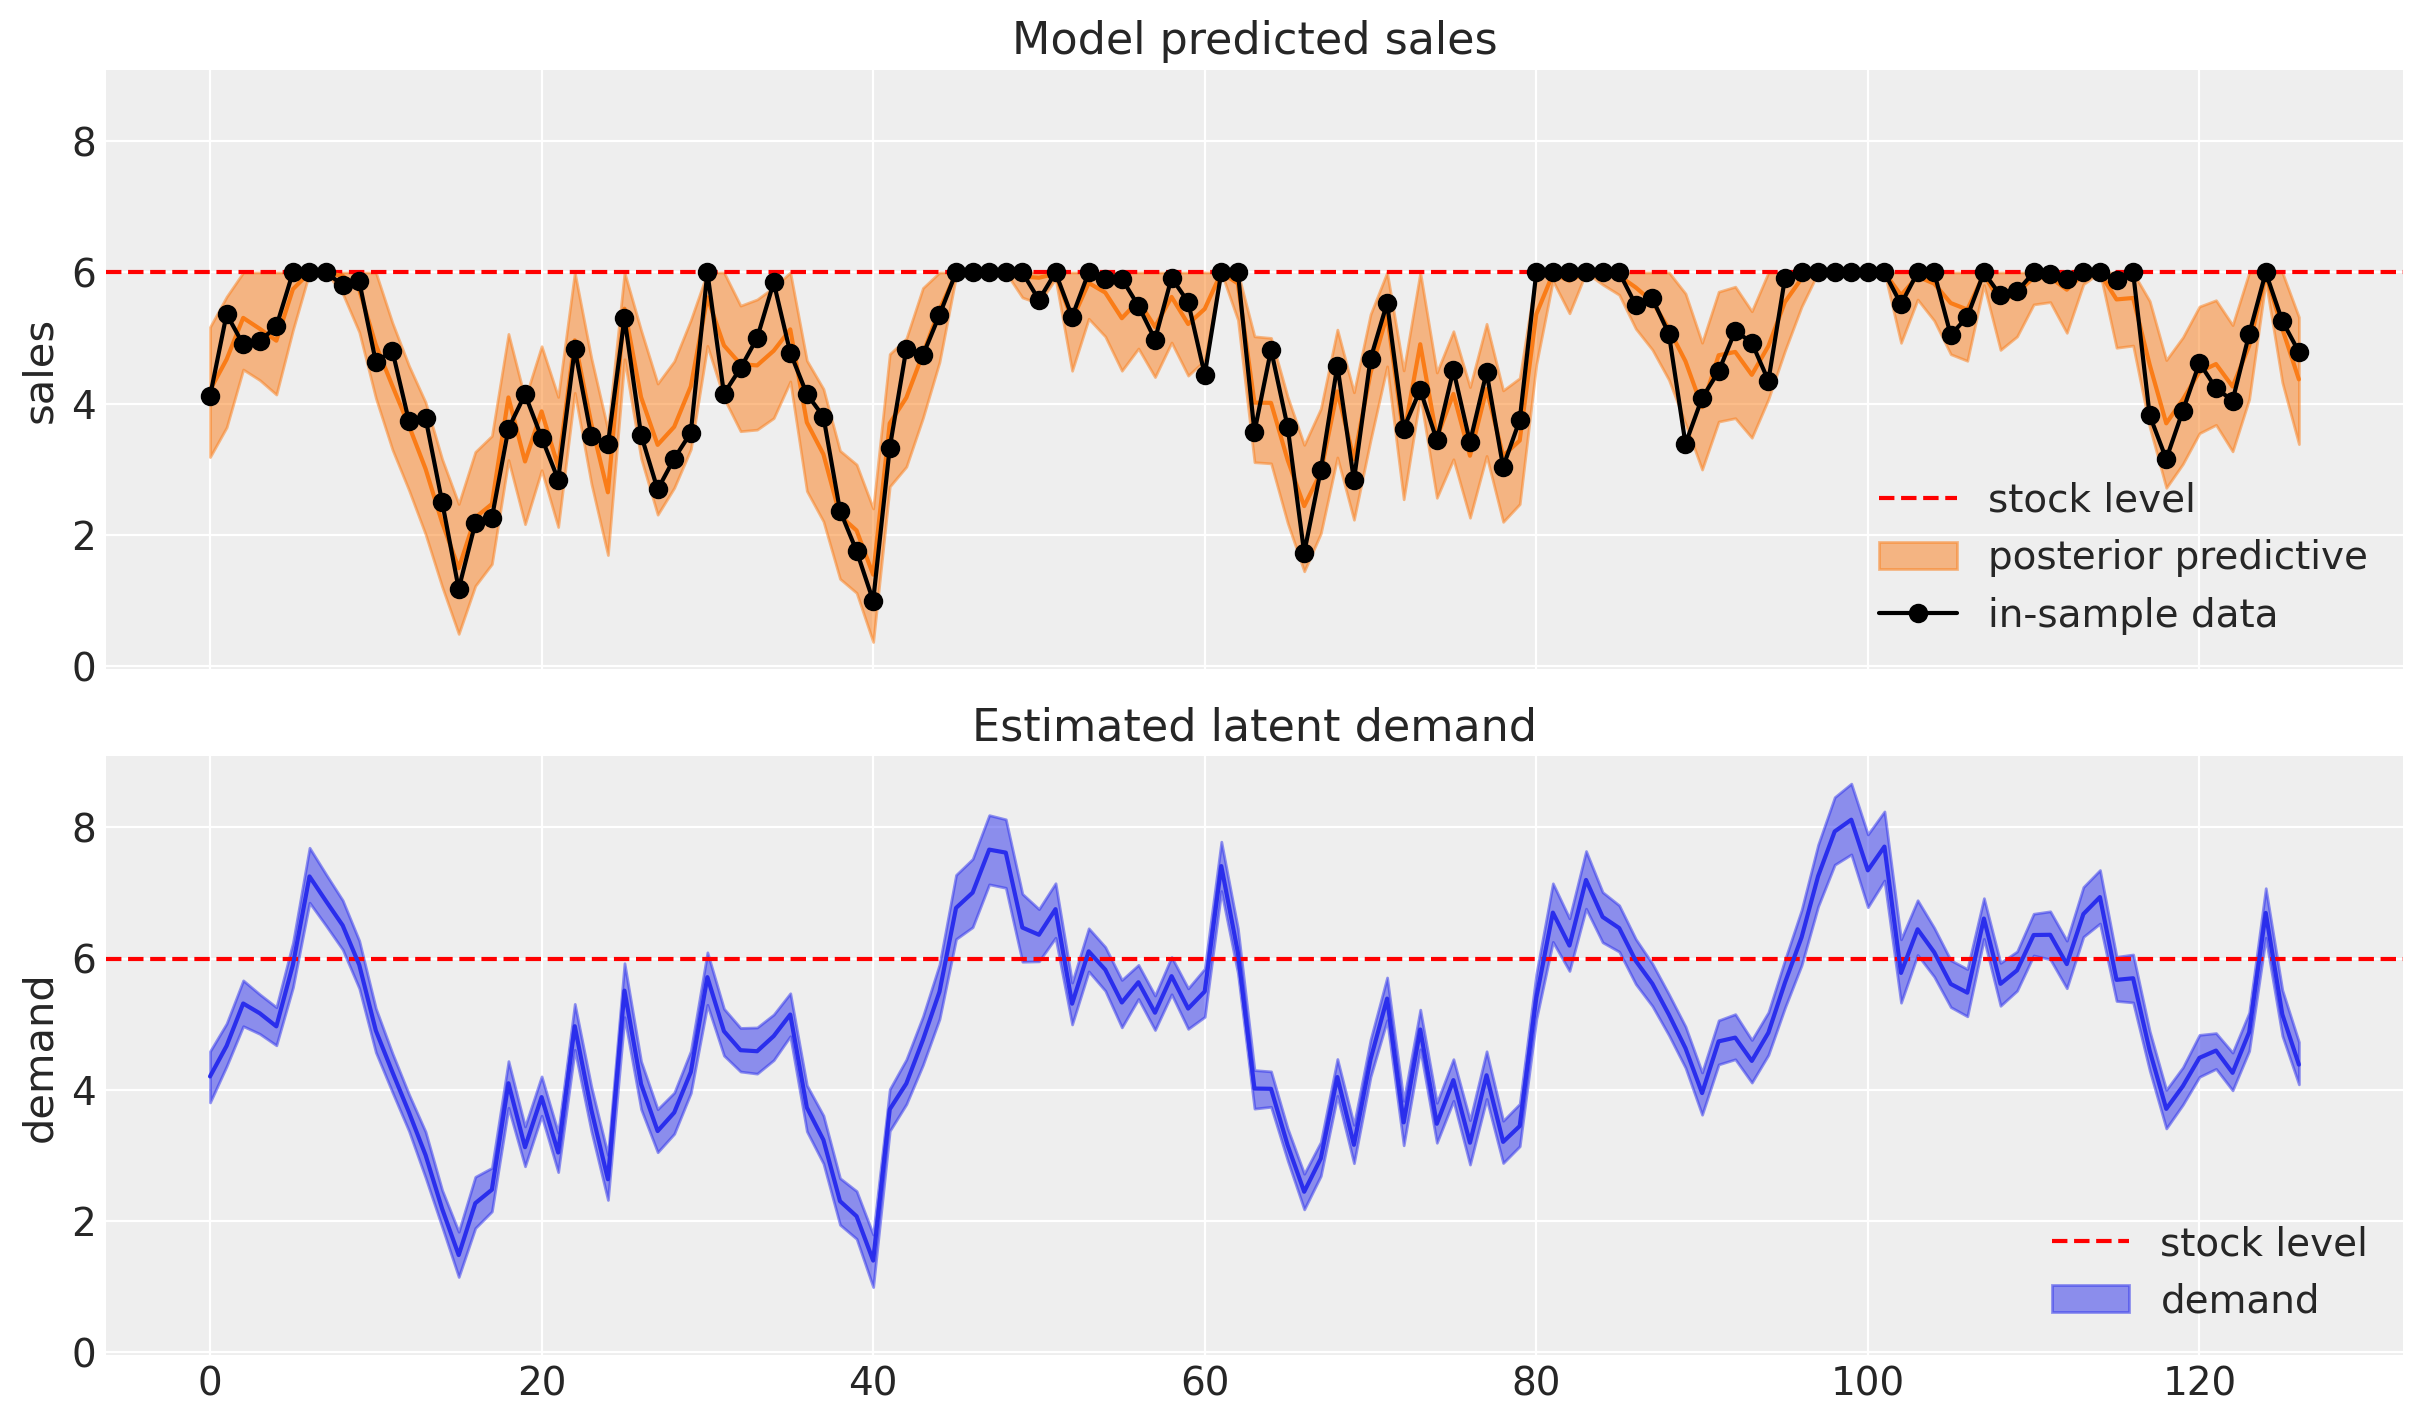

In [17]:
def plot_in_sample_data(idata, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    x = idata.constant_data["t"]
    y = idata.observed_data["sales"]
    ax.plot(x, y, "ko-", label="in-sample data")
    return ax


def plot_posterior_predictive(
    idata: az.InferenceData, var_name="sales", ax=None, col="C0", label=None
):
    if ax is None:
        fig, ax = plt.subplots()
    x = idata.constant_data["t"]
    az.plot_hdi(
        x,
        idata.posterior_predictive[var_name],
        smooth=False,
        fill_kwargs={"label": label, "color": col},
        ax=ax,
    )
    ax.plot(
        x, idata.posterior_predictive[var_name].mean(dim=["chain", "draw"]), color=col
    )
    return ax


fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

# SALES PLOT
ax[0].axhline(y=params["stock_level"], color="red", linestyle="--", label="stock level")
plot_posterior_predictive(
    idata, var_name="sales", label="posterior predictive", ax=ax[0], col="C1"
)
plot_in_sample_data(idata, ax[0])
ax[0].legend()
ax[0].set(ylabel="sales", title="Model predicted sales")

# DEMAND PLOT
ax[1].axhline(y=params["stock_level"], color="red", linestyle="--", label="stock level")
plot_posterior_predictive(idata, var_name="demand", ax=ax[1], col="C0", label="demand")
ax[1].set(ylabel="demand", title="Estimated latent demand")
ax[1].legend();

# plt.savefig("img/model_fit.png", bbox_inches="tight", dpi=300, facecolor="white");

### Additional insights: decompose drivers of demand

<Axes: >

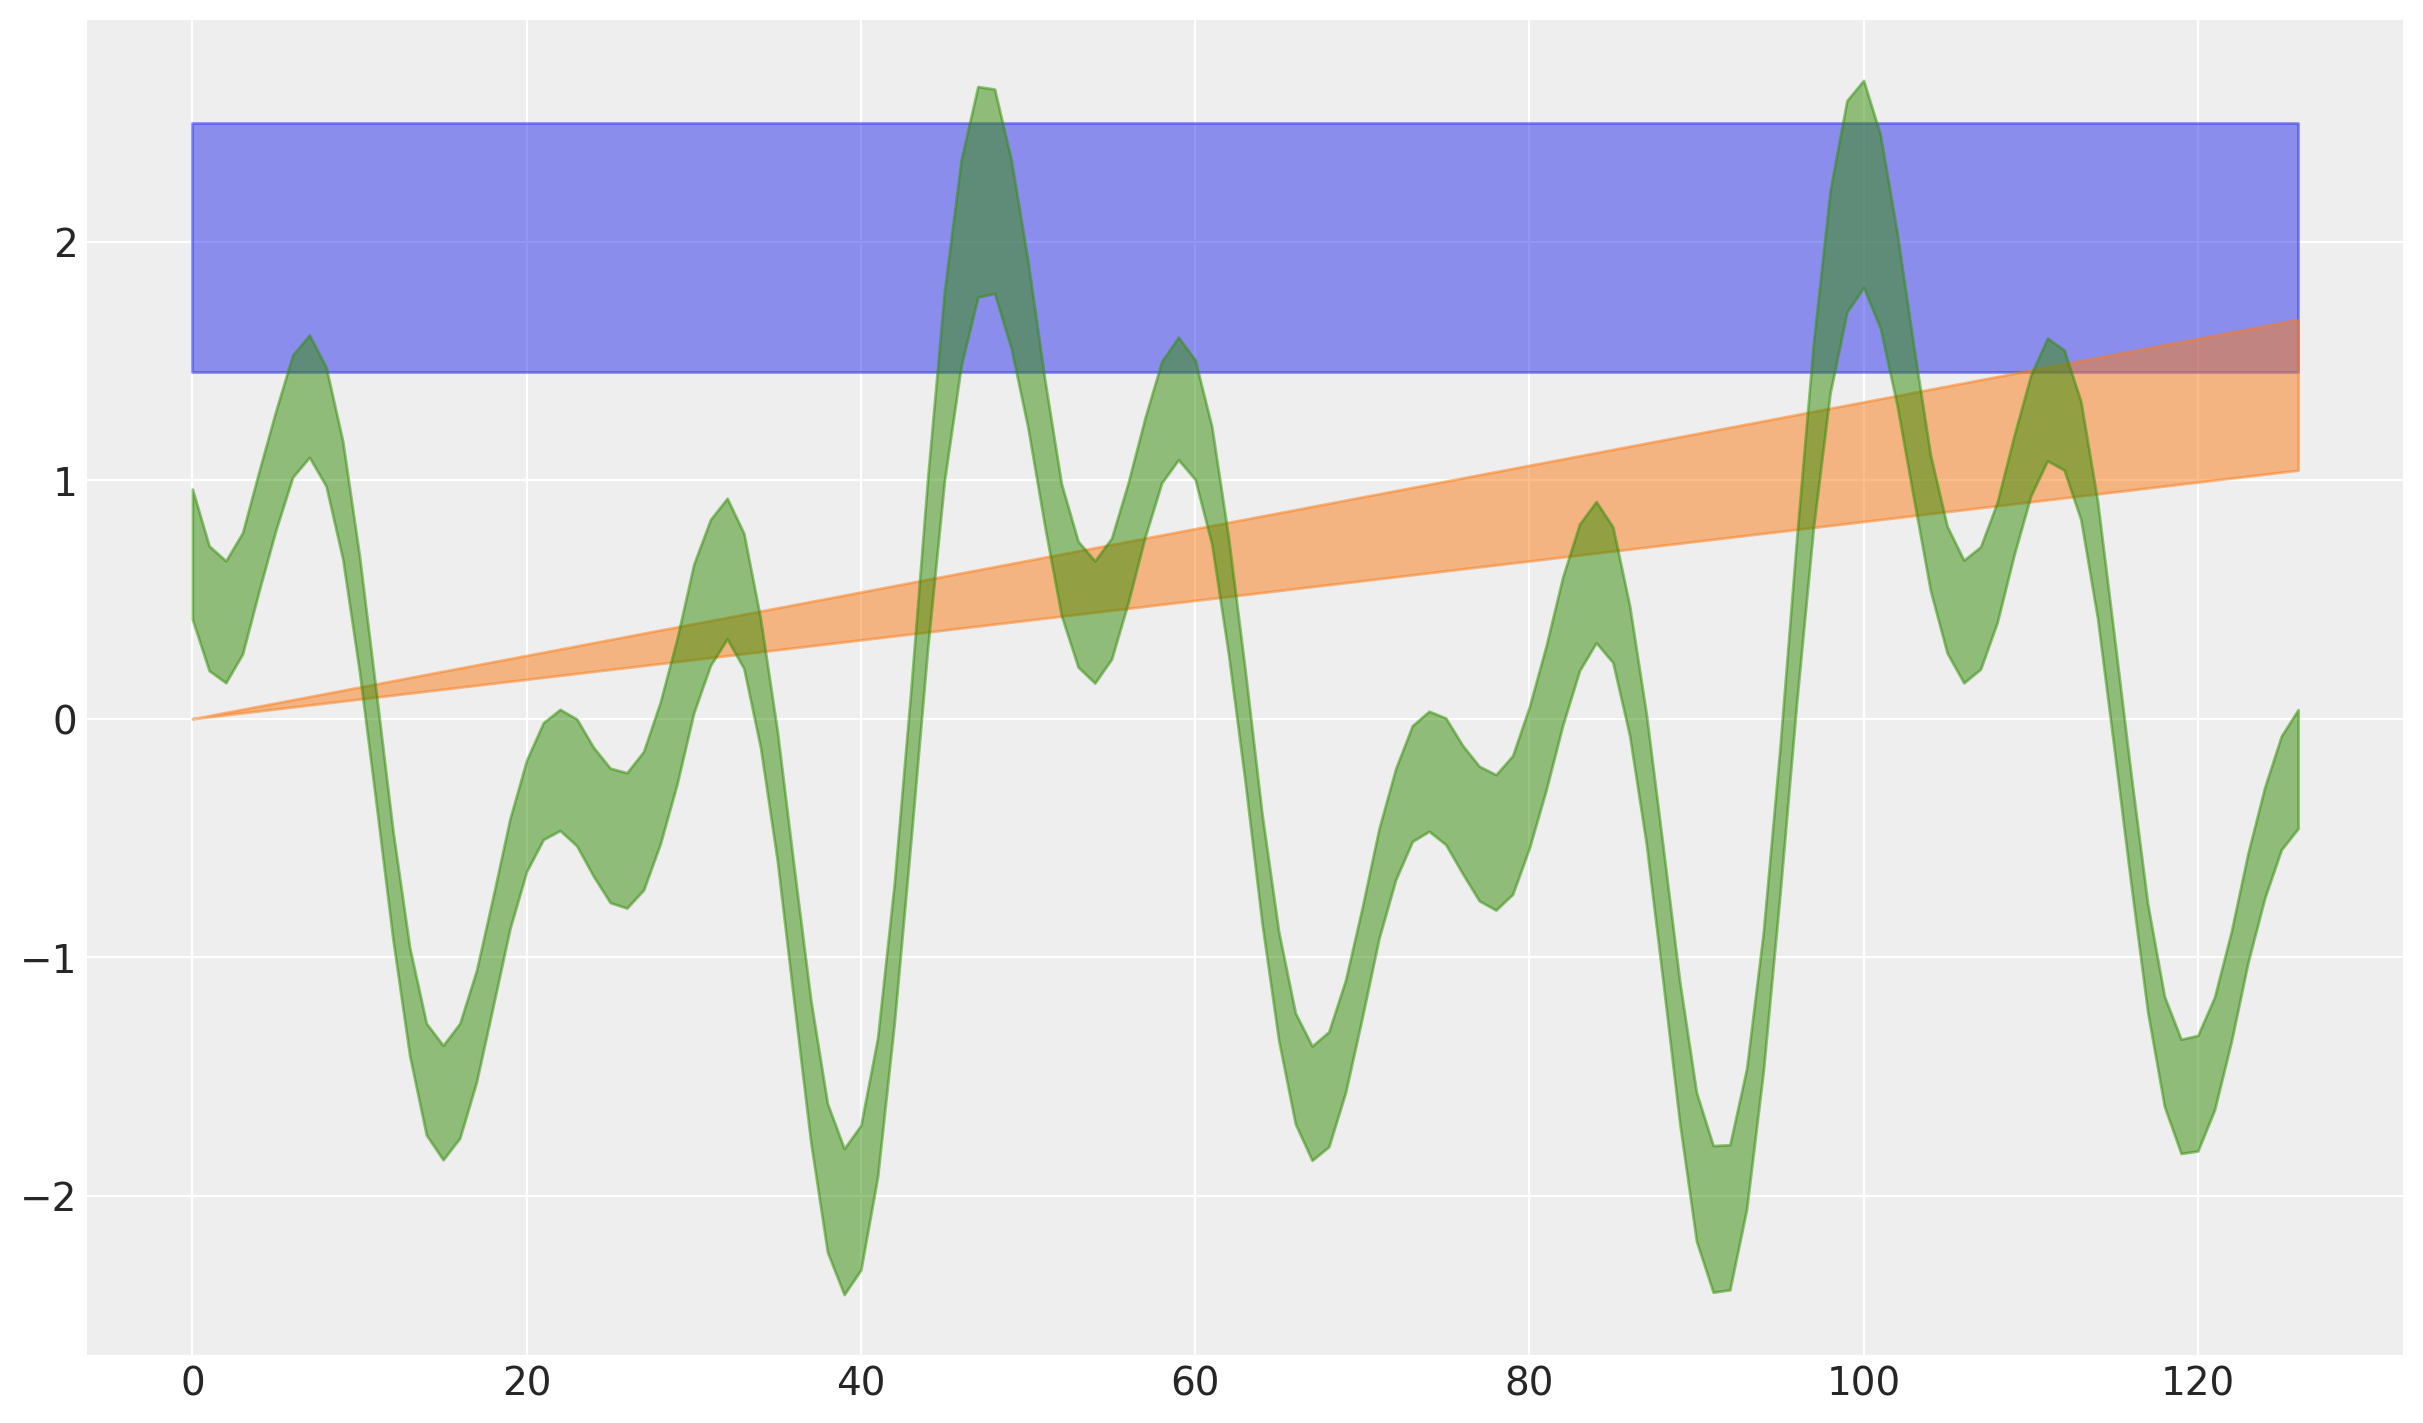

In [18]:
fig, ax = plt.subplots(sharex=True)

# intercept
n_observations = exogenous["t"].shape[0]
ones_array = xr.DataArray(
    np.ones(n_observations),
    dims="obs",
    coords={"obs": idata.constant_data["t"].coords["obs"]},
)
intercept = idata.posterior["beta_intercept"] * ones_array
az.plot_hdi(
    idata.constant_data["t"],
    intercept,
    smooth=False,
    fill_kwargs={"label": "intercept", "color": "C0"},
    ax=ax,
)

# trend
trend_component = idata.posterior["beta_trend"] * idata.constant_data["t"]
az.plot_hdi(
    idata.constant_data["t"],
    trend_component,
    smooth=False,
    fill_kwargs={"label": "trend", "color": "C1"},
    ax=ax,
)

# seasonality
S = idata.constant_data["S"]
beta_seasonality = idata.posterior["beta_seasonality"]
dot_product = xr.dot(S, beta_seasonality, dims="bases").transpose(
    "chain", "draw", "obs"
)
# dot_product
az.plot_hdi(
    idata.constant_data["t"],
    dot_product,
    smooth=False,
    fill_kwargs={"label": "seasonality", "color": "C2"},
    ax=ax,
)

### Additional insights: lost sales + wasted products

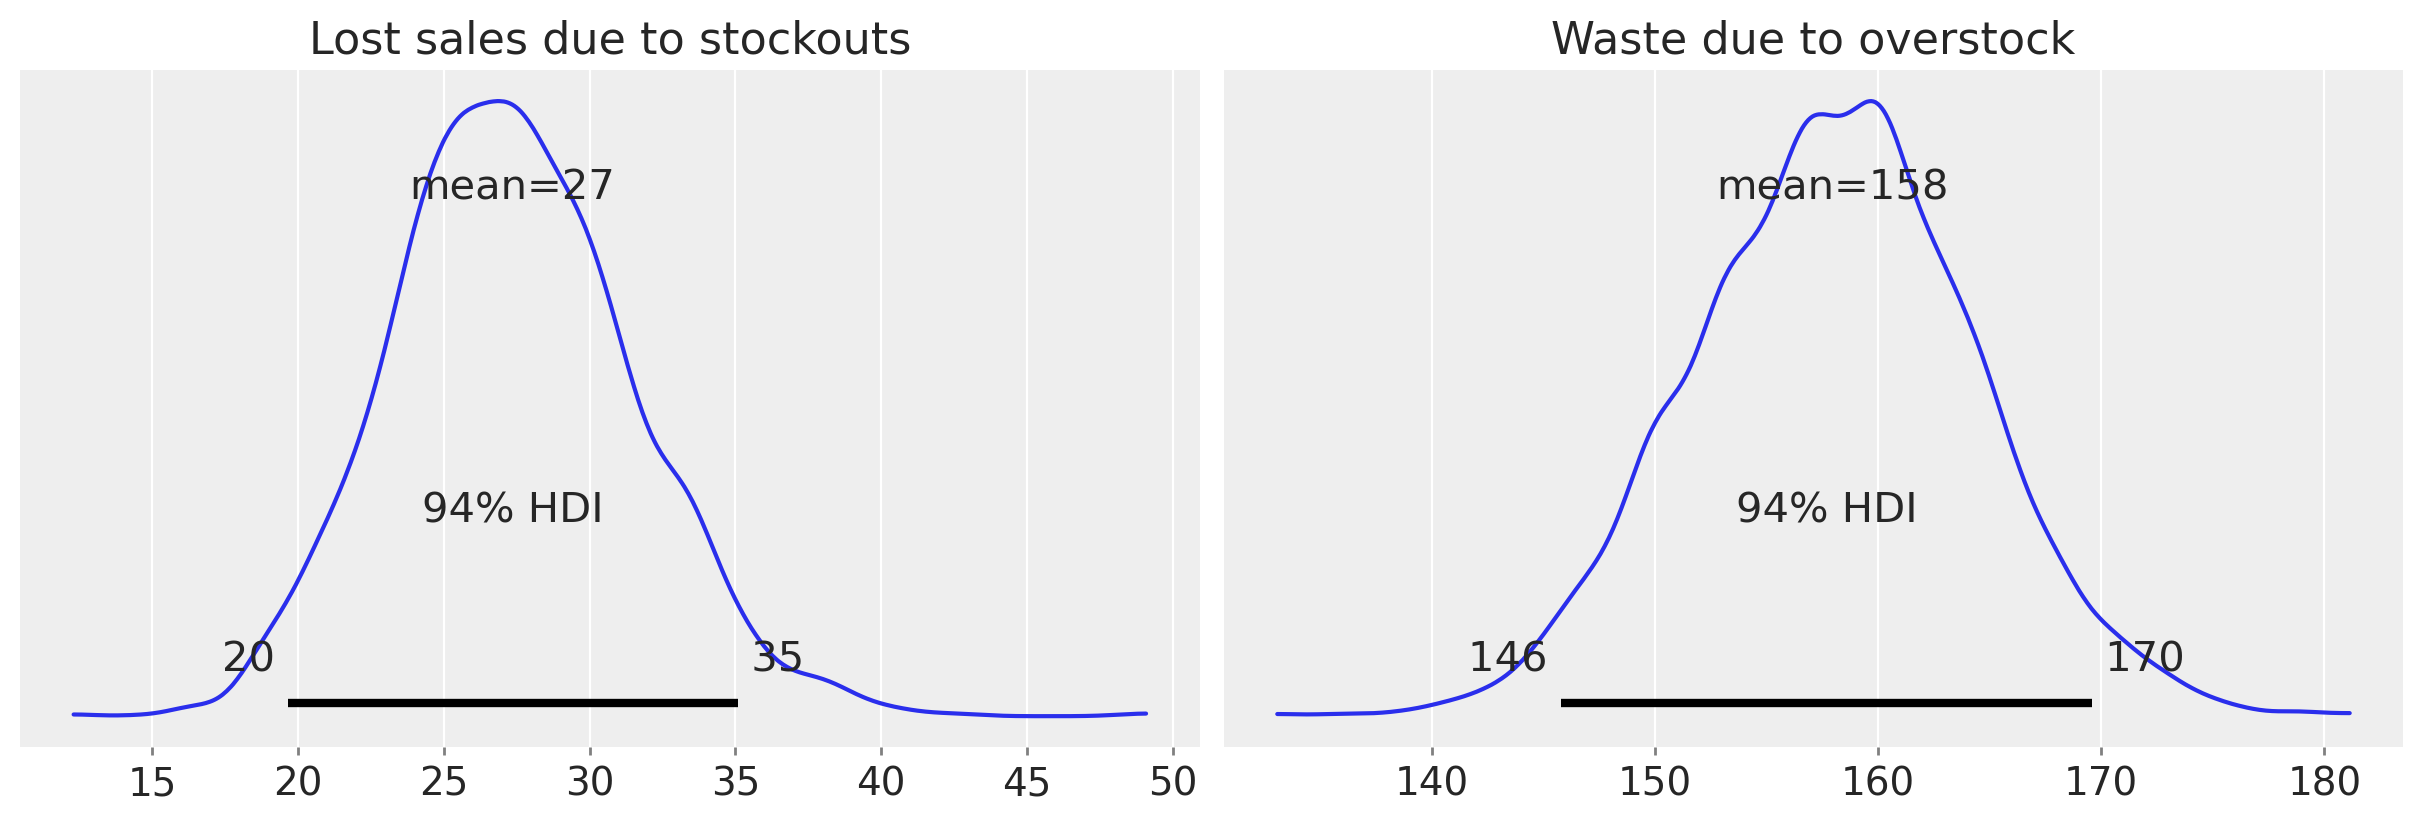

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

lost_sales = (
    (idata.posterior_predictive["demand"] - idata.constant_data["stock_level"])
    .clip(min=0)
    .sum(dim="obs")
)
az.plot_posterior(lost_sales, ax=ax[0])
ax[0].set(title="Lost sales due to stockouts")

waste = (
    (idata.constant_data["stock_level"] - idata.posterior_predictive["sales"])
    .clip(min=0)
    .sum(dim="obs")
)
az.plot_posterior(waste, ax=ax[1])
ax[1].set(title="Waste due to overstock");

# plt.savefig(
#     "img/lost_sales_and_waste.png", bbox_inches="tight", dpi=300, facecolor="white"
# );

## Step 1 - forecasting

In [20]:
"""
The things of functional importance here are:
- create an intervention dictionary
- create a new model having applied the intervention to an original model graph

However, the API around `do` and `observe` is still in flux, so we have to faff about a bit.
So what we have to do is:
1. Create a copy of `model`. It would have maybe made more sense to copy `model_simulate`, but we have shape issues
2. Update the dimensions of the new model to match the new data shape
3. Create the intervention dictionary
4. Apply the intervention to the new model with the `do` operator
5. Run posterior predictive sampling
"""

# create a new model (based on `model`) then manually change the dims to fit with the new shape of the data for forecasting
model_step1 = model.copy()

# update dims of the model
n_observations = exogenous.shape[0]
n_new_periods = 28 * 6  # <- forecast N months ahead
t = np.arange(n_observations + 1, n_observations + 1 + n_new_periods)

model_step1.set_dim("obs", n_new_periods, t)

In [21]:
# Now generate our intervention
forecast_df = generate_fourier_basis(
    pd.DataFrame().assign(t=t), day_col="t", n_order=params["seasonality_norder"]
)
intervention = {
    "t": t,
    "x1": exogenous["x1"].mean() * np.ones(n_new_periods),
    "x2": exogenous["x2"].mean() * np.ones(n_new_periods),
    "S": extract_seasonality_to_array(forecast_df),
    "stock_level": exogenous["stock_level"].mean() * np.ones(n_new_periods),
}

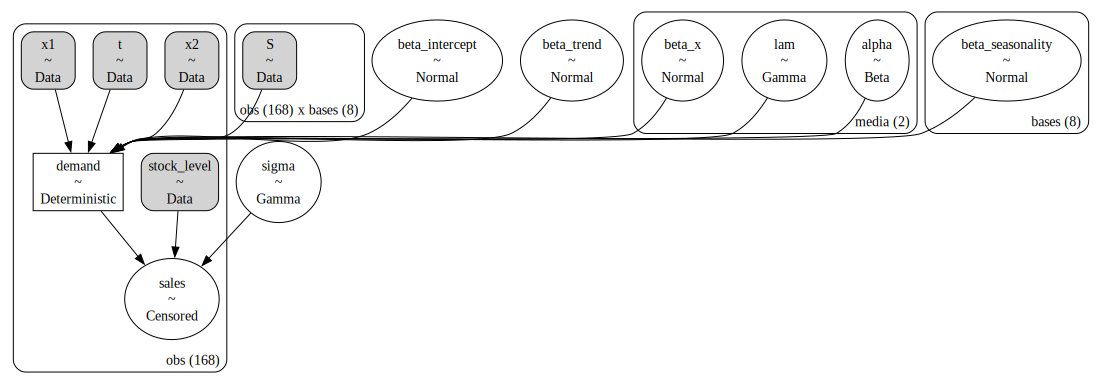

In [22]:
# apply the intervention with pm.do
model_step1 = pm.do(model_step1, intervention)
model_step1.to_graphviz()

In [23]:
"""
If we use a adstock function then ideally the posterior predictive sampling should include 
some observations from the recent past so that the decay function can be applied to them.
Won't be too hard to do, see the docs
https://github.com/pymc-labs/pymc-marketing/blob/9e1a89e628e14e3b7faa85cc130af0a12b46b29e/pymc_marketing/mmm/mmm.py#L1834
You basically concatenate the end of the past data, do the posterior prediction, then 
slice those dates out of the idata.
"""

with model_step1:
    idata_step1 = pm.sample_posterior_predictive(idata, var_names=["demand", "sales"])

#  TODO: if the API changes in the future, we can set `predictions=True`. This allows the dims to change shape without having to manually update them??

Sampling: [sales]


Output()

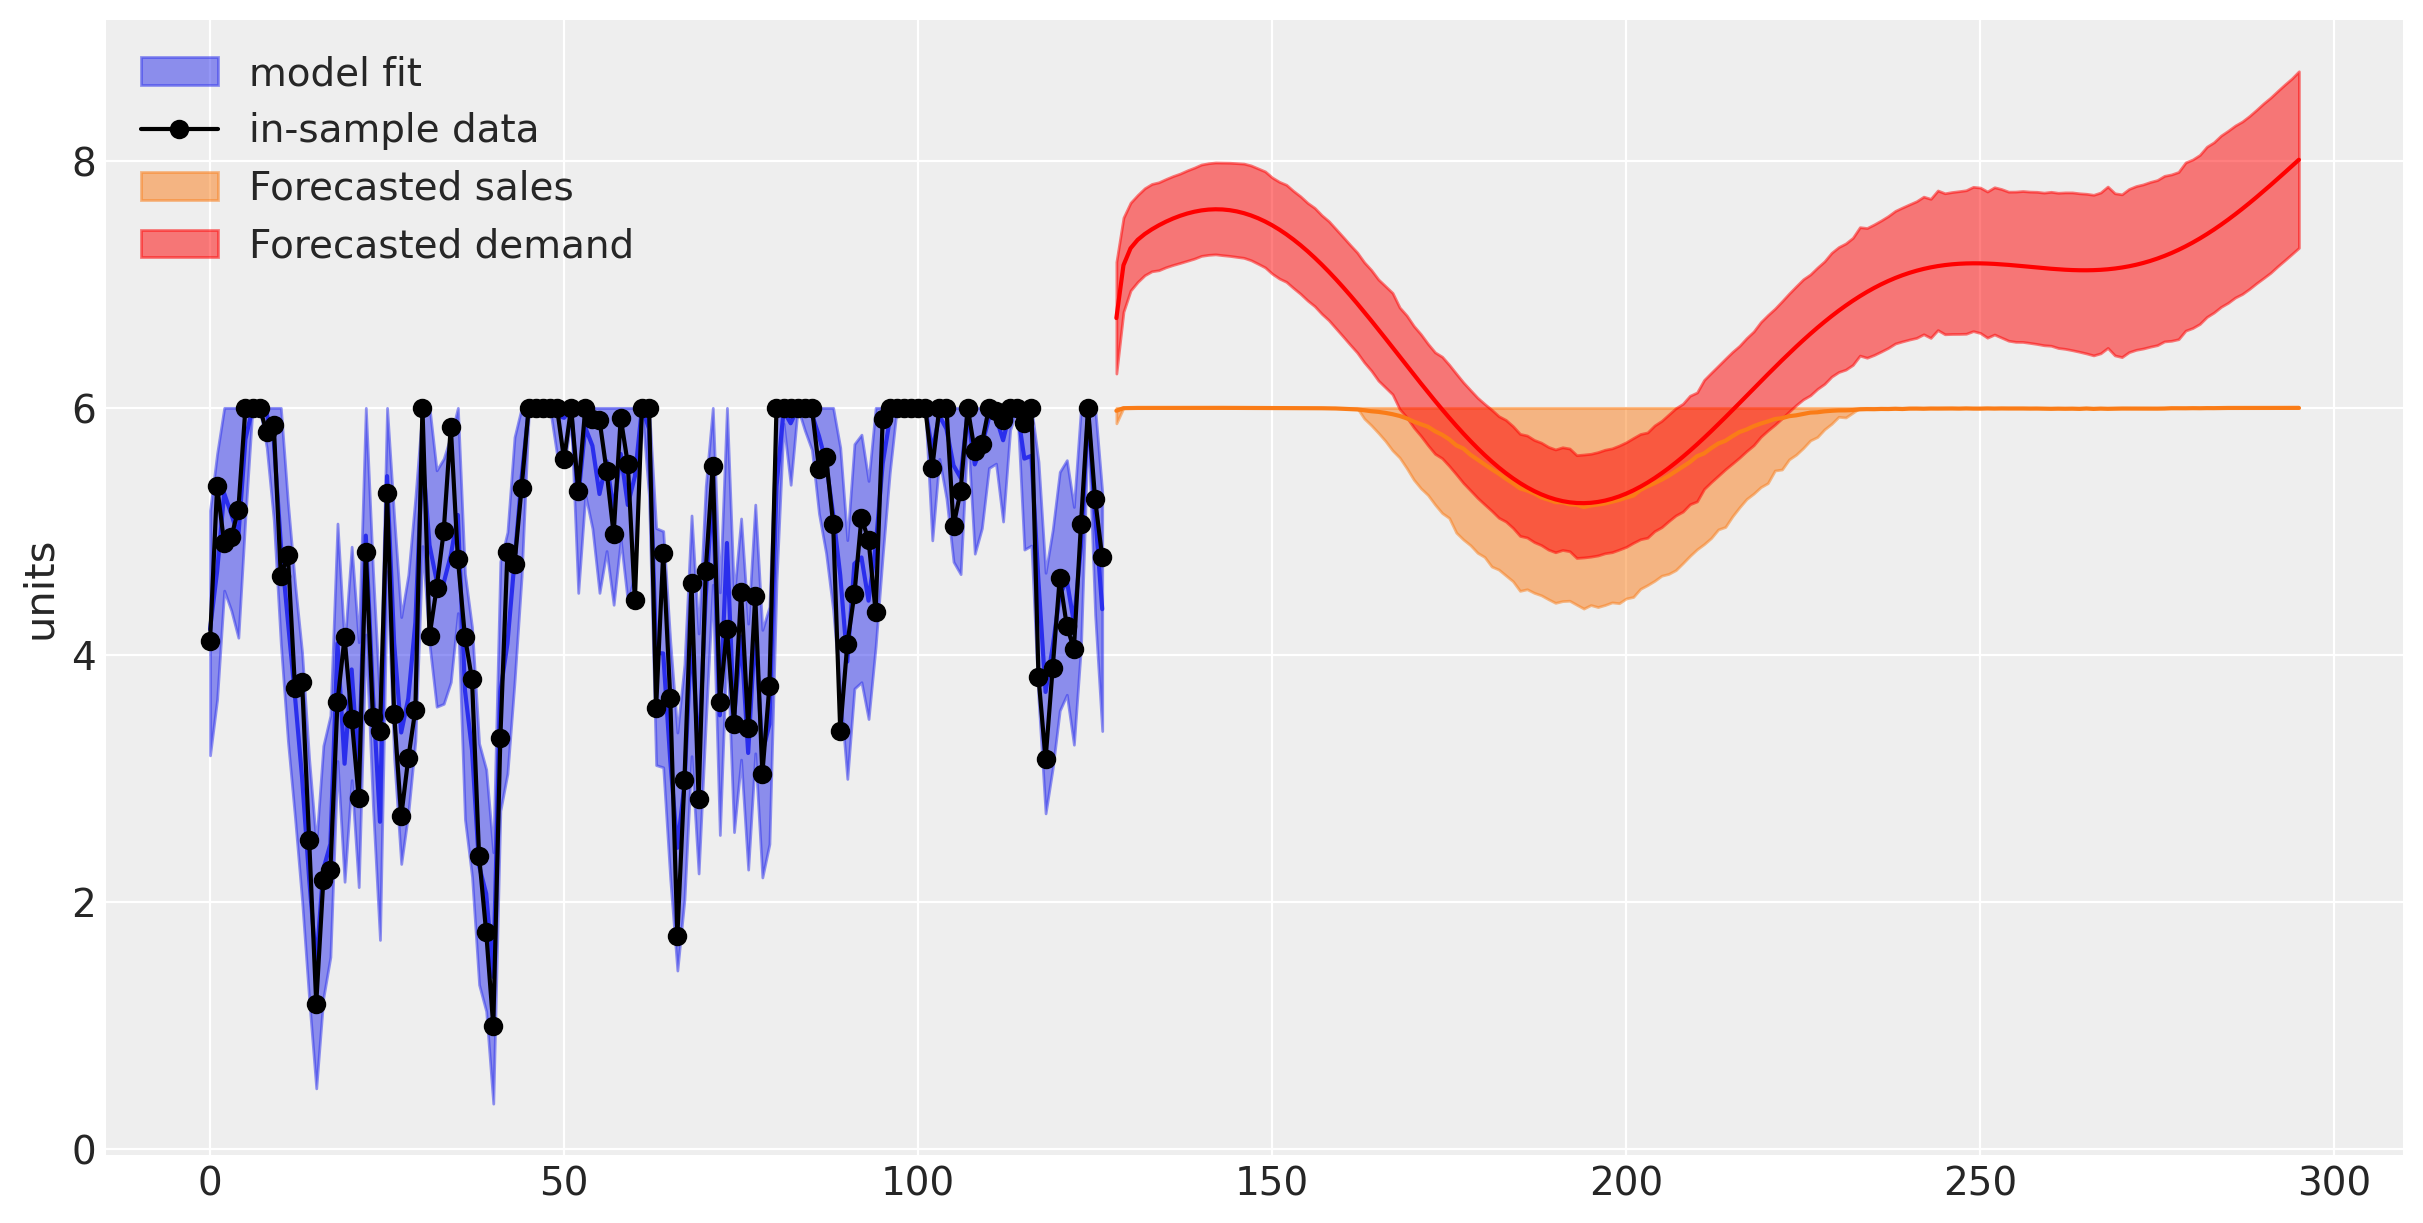

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
# plot data and model fit
plot_posterior_predictive(idata, label="model fit", ax=ax)
plot_in_sample_data(idata, ax)

# plot Step 1 forecast
plot_posterior_predictive(
    idata_step1, var_name="sales", ax=ax, col="C1", label="Forecasted sales"
)

# demand
plot_posterior_predictive(
    idata_step1, var_name="demand", ax=ax, col="red", label="Forecasted demand"
)

ax.legend()
ax.set(ylabel="units");

# plt.savefig(
#     "img/step_1_forecasting.png", bbox_inches="tight", dpi=300, facecolor="white"
# )

## Step 2 - intervention

In [25]:
# copy the intervention from Step 1, but change the stock_level values
intervention["stock_level"] = params["stock_level"] * 1.2 * np.ones(n_new_periods)


# apply the intervention with pm.do
model_step2 = pm.do(model_step1, intervention)

# run the posterior predictive sampling
with model_step2:
    idata_step2 = pm.sample_posterior_predictive(idata, var_names=["demand", "sales"])

Sampling: [sales]


Output()

[Text(0, 0.5, 'units')]

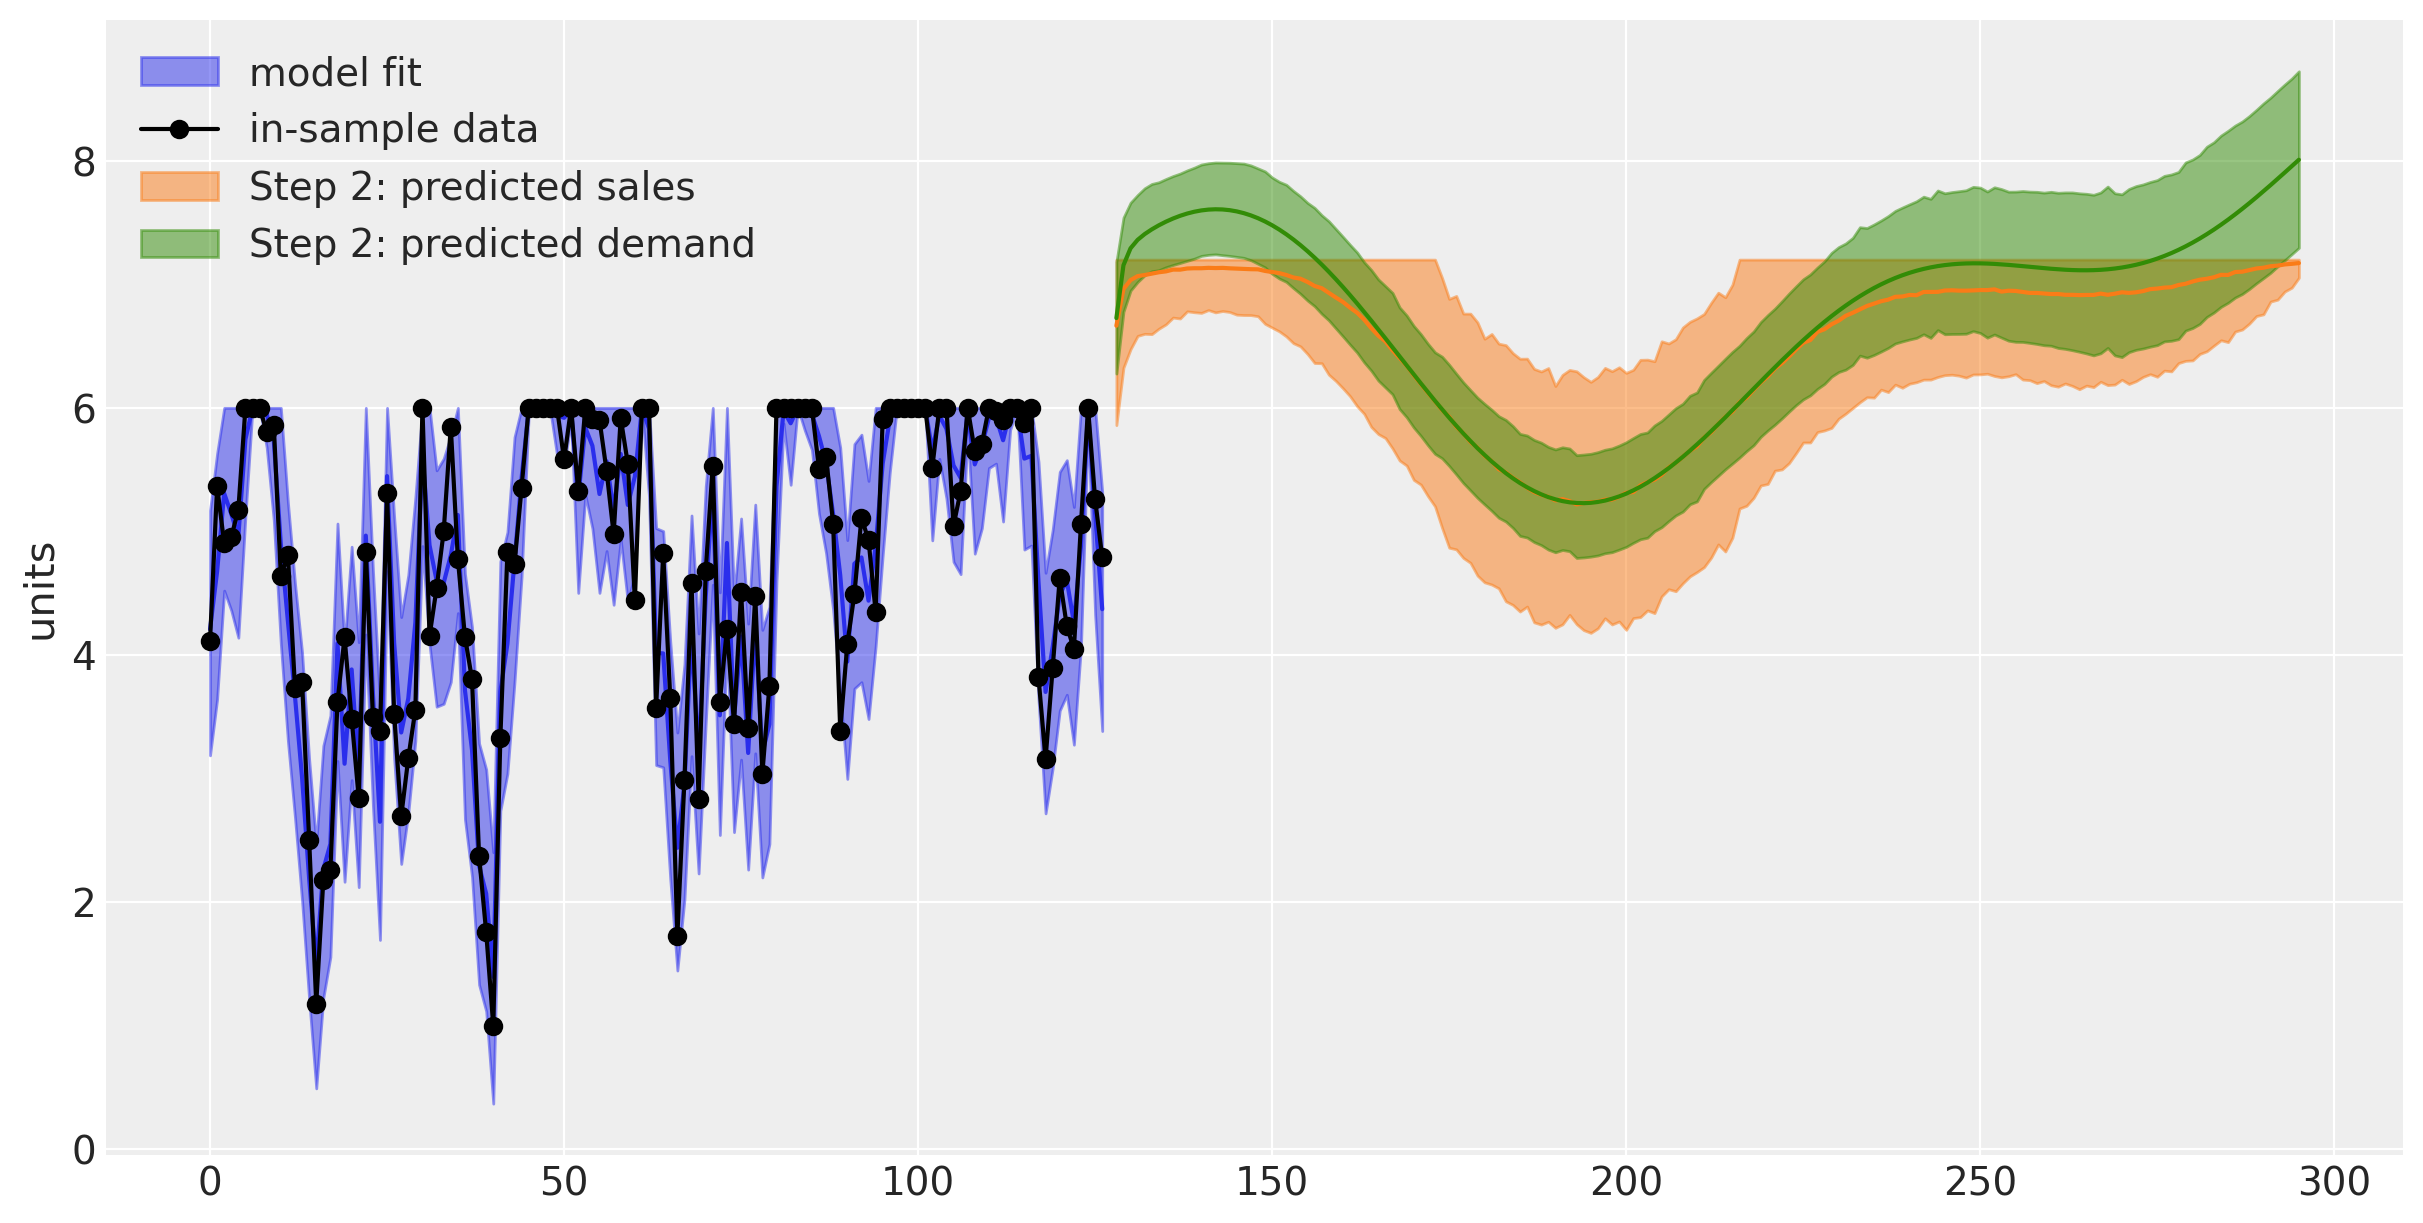

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot data and model fit
plot_posterior_predictive(idata, label="model fit", ax=ax)
plot_in_sample_data(idata, ax)

# Plot Step 2 forecast of sales
plot_posterior_predictive(idata_step2, ax=ax, col="C1", label="Step 2: predicted sales")

# Add the posterior predicted demand
plot_posterior_predictive(
    idata_step2, var_name="demand", ax=ax, col="C2", label="Step 2: predicted demand"
)

ax.legend()
ax.set(ylabel="units")

# plt.savefig(
#     "img/step_2_intervention.png", bbox_inches="tight", dpi=300, facecolor="white"
# )

## Step 3 - counterfactuals

In [27]:
counterfactual = {
    "t": exogenous["t"],
    "x1": exogenous["x1_counterfactual"],  # <- the counterfactual
    "x2": exogenous["x2"],
    "S": extract_seasonality_to_array(exogenous),
    "stock_level": exogenous["stock_level"],
}

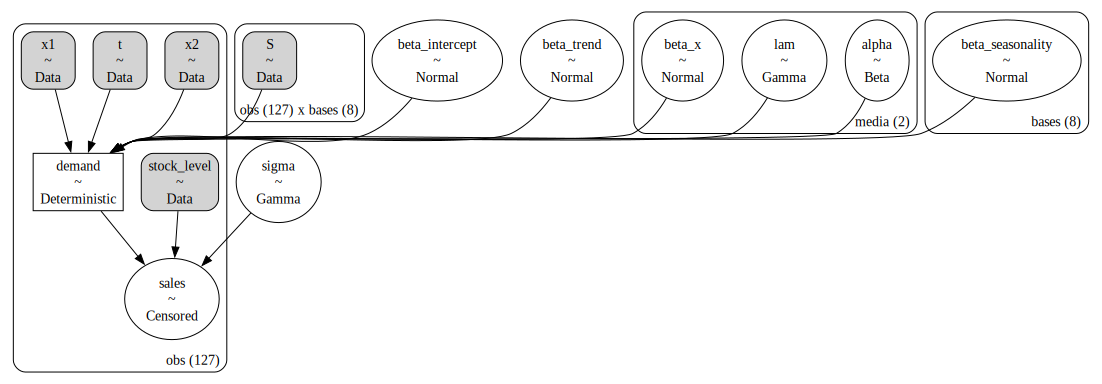

In [28]:
model_step3 = pm.do(model, counterfactual)
model_step3.to_graphviz()

In [29]:
with model_step3:
    idata_step3 = pm.sample_posterior_predictive(idata, var_names=["demand", "sales"])

Sampling: [sales]


Output()

[Text(0.5, 1.0, 'Cumulative causal impact')]

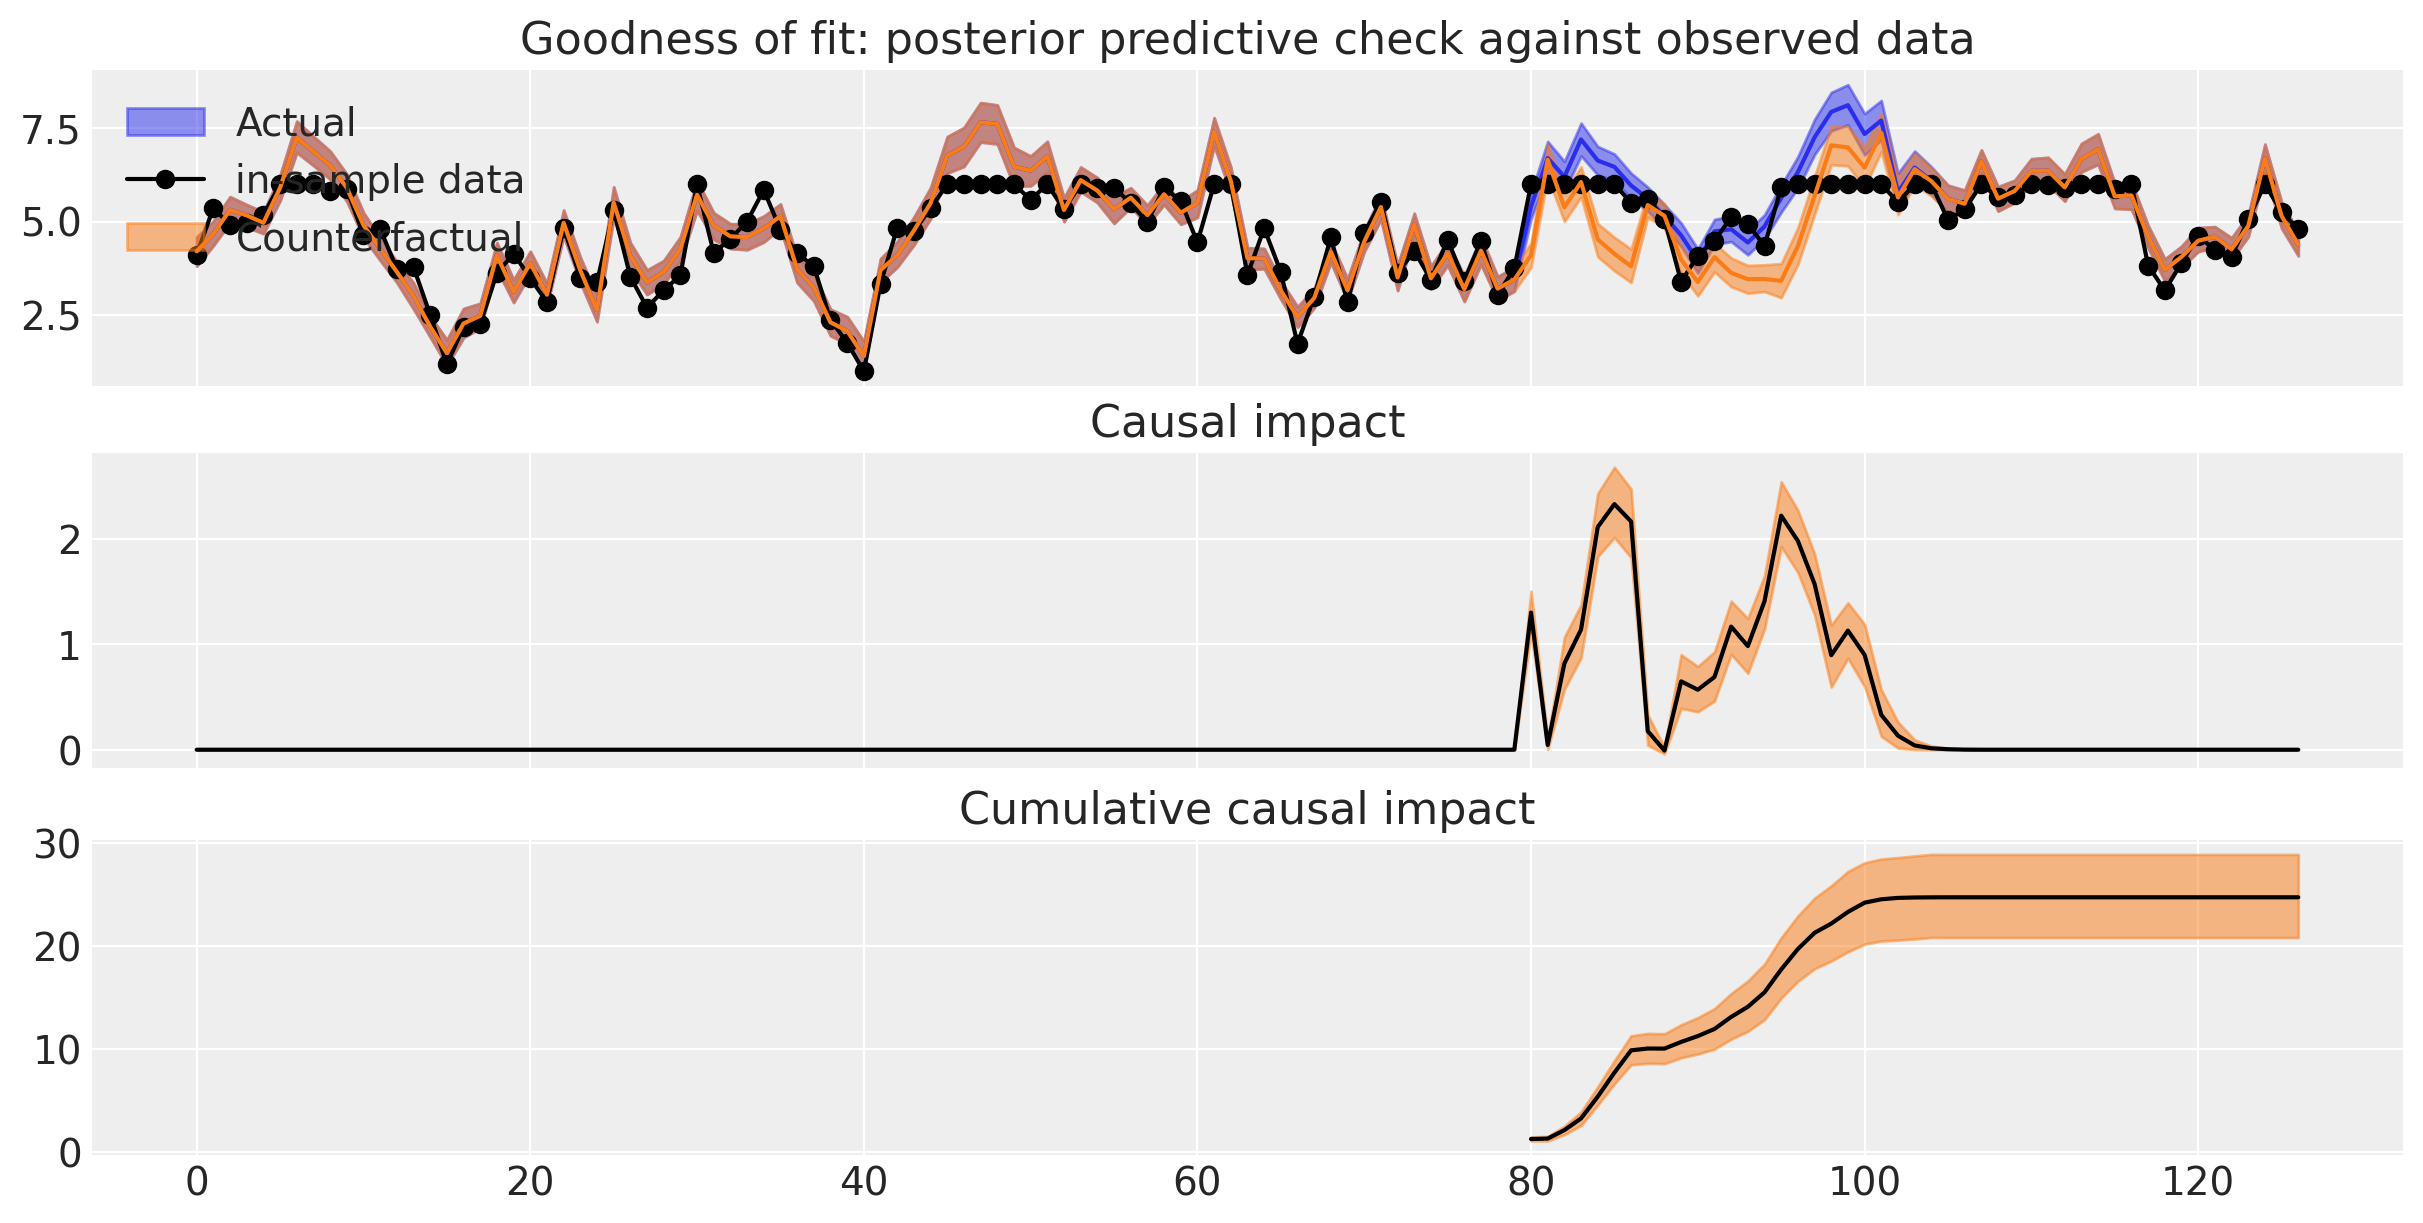

In [30]:
var_name = "demand"

fig, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

_ = plot_posterior_predictive(idata, var_name=var_name, ax=ax[0], label="Actual")
_ = plot_in_sample_data(idata, ax=ax[0])
plot_posterior_predictive(
    idata_step3, var_name=var_name, ax=ax[0], col="C1", label="Counterfactual"
)
ax[0].legend()
ax[0].set(title="Goodness of fit: posterior predictive check against observed data")


causal_impact = (
    idata.posterior_predictive[var_name] - idata_step3.posterior_predictive[var_name]
)
az.plot_hdi(np.arange(127), causal_impact, smooth=False, ax=ax[1])
ax[1].plot(np.arange(127), causal_impact.mean(dim=["chain", "draw"]), "k-")
ax[1].set(title="Causal impact")


cum_causal_impact = causal_impact.sel(obs=slice(80, None)).cumsum(dim="obs")

az.plot_hdi(cum_causal_impact.obs, cum_causal_impact, smooth=False, ax=ax[2])
ax[2].plot(cum_causal_impact.obs, cum_causal_impact.mean(dim=["chain", "draw"]), "k")

ax[2].set(title="Cumulative causal impact")

# plt.savefig(
#     "img/step_3_counterfactual.png", bbox_inches="tight", dpi=300, facecolor="white"
# )

In [31]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor

Last updated: Thu Dec 05 2024

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

pymc_marketing: 0.6.0
pytensor      : 2.26.3

numpy         : 1.26.4
graphviz      : 0.20.3
arviz         : 0.20.0
matplotlib    : 3.9.2
IPython       : 8.29.0
pymc_marketing: 0.6.0
xarray        : 2024.11.0
pandas        : 2.2.3
pymc          : 5.18.2

Watermark: 2.5.0

